Okay I still should check that boltzmann stuff is working properly before doing the Q-values, so try running the boltzmann on the reward matrix rather than the q values and check that it gives you the distribution you'd expect just to make sure I'm not messing anything up there. 

Then if that's all fine, which it probably is, have another look at the Q-value and V-Value calculations in learn, and if they look right then step through and check that it's doing what I expect them to be doing. 

If it's something wrong with one of those then that might fix the learning side of things as well, but at least we'll have a proper trajectory to learn from because atm the one it's creating, and the resulting policy is abysmal, so fix that first, get the expert to perform more expertly and then you can check to see if there are problems with the learning algorithm :) 

Issue has to be in policy iteration somewhere 

In [ ]:
%reload_ext autoreload
from env import SingleStateSpace 
from generate_trajectory import generate_trajectory
from policy import Boltzmann 
from learn import compute_q_with_values
from RewardFunctions import SingleStateReward
import numpy as np 
from learn import policy_iteration
from utils import normalise_pi
from policy_walk import policy_walk 
import matplotlib.pyplot as plt 

In [17]:
#Set up the environment
trajectory_length = 20 
env = SingleStateSpace(n_actions = 10, discount_rate = 0.1, R_max = 5)

#generate observation times 
observation_times = np.cumsum(np.random.uniform(0, 2, size=trajectory_length))
print("Generated observation times:") 
print(observation_times)

#Create a matrix for the true rewards 
s_grid, a_grid, t_grid = np.meshgrid(env.states, env.actions, observation_times, indexing='ij')
R = np.vectorize(env.reward)(s_grid,a_grid,t_grid)

#Find the optimal policy, values and q_values for the true reward to generate the trajectory. 
(optimal_pi, optimal_values, optimal_q_values) = policy_iteration(env,trajectory_length,R)
b = Boltzmann(optimal_q_values, env.actions, alpha = 5)
observations = generate_trajectory(env,b,observation_times, n_trajectories=20)

print("Generated trajectory") 
# print(observations)

#Sample from policy walk - I discard the first half of each policy walk iteration.
learned_rewards = policy_walk(env,observations,n_observations = trajectory_length,n_iters=1000)[500:1000]
policy_walk_iters = 200
for _ in range(policy_walk_iters-1): 
    learned_rewards = np.concatenate((learned_rewards, policy_walk(env,observations, n_observations = trajectory_length,n_iters=1000)[500:1000]))

Generated observation times:
[9.29868407e-03 1.00225326e+00 2.13949875e+00 2.28662830e+00
 2.33334379e+00 3.01913613e+00 3.26691172e+00 4.32621570e+00
 4.56690129e+00 5.75556269e+00 7.20723485e+00 8.79044999e+00
 9.79806263e+00 1.11412125e+01 1.13901868e+01 1.30783467e+01
 1.43086827e+01 1.54201421e+01 1.57235513e+01 1.68486244e+01]
Generated trajectory


c:\Users\tomms\Desktop\IRL Project\IRLProject\src\policy_walk.py:25: RuntimeWarning: invalid value encountered in double_scalars
  ratio = calculate_posterior(env,observations,n_observations, R_tild, env.R_max, pi_tild)/calculate_posterior(env,observations, n_observations, R, env.R_max, pi)


In [ ]:
learned_rewards = np.asarray(learned_rewards) 
learned_rewards.shape 
s,a = 0,3

for t in range(trajectory_length):
    rewards = [] 
    for iter in range(learned_rewards.shape[0]):
        rewards.append(learned_rewards[iter,s,a,t])
    plt.plot(rewards) 
    plt.xlabel("Iteration") 
    ylabel = "Reward for (s,a,t) = ("  + format(s) + "," + format(a) + "," + format(t) + ")"
    plt.ylabel(ylabel)
    plt.show()



[9.29868407e-03 1.00225326e+00 2.13949875e+00 2.28662830e+00
 2.33334379e+00 3.01913613e+00 3.26691172e+00 4.32621570e+00
 4.56690129e+00 5.75556269e+00 7.20723485e+00 8.79044999e+00
 9.79806263e+00 1.11412125e+01 1.13901868e+01 1.30783467e+01
 1.43086827e+01 1.54201421e+01 1.57235513e+01 1.68486244e+01]


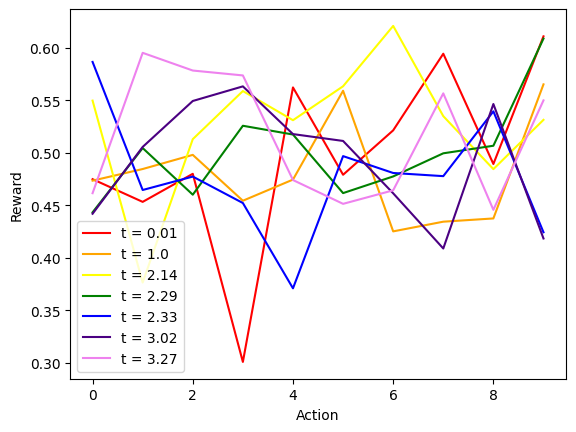

In [18]:
avg_reward = np.average(np.asarray(learned_rewards),axis = 0)
print(observation_times)
colors = ["red", "orange","yellow","green","blue","indigo","violet"]
for t in range(7):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(avg_reward[0,:,t], color=colors[t], label = label)
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()